# **How many people live here?**
### *Training a neural network to guess the population of an area by looking at a satellite image*
--

What's your favorite place to go on a Friday night?

Mine is Google Earth. I've spent countless wild evenings there, exploring everything from the rivers of Congo to the suburbs of Chicago.

As if satellite imagery wasn't already great enough just by virtue of allowing us to view the furthest corners of our planet, it's also a potent source of data that can be leveraged for predictive AI. Satellite images contain valuable information about water supply, forestation, accessibility, climate conditions, and much more. For this project though, I intend to focus on the information they contain about human population.

Take, for example, these two images:  

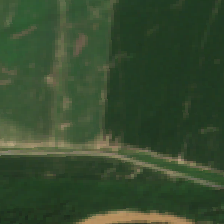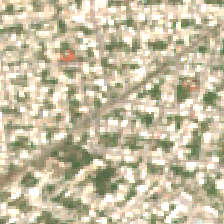

If I were to ask you which of those areas has the highest population, I venture that you, as a human, would have no problems guessing that. While "asking a human" remains the optimal solution to a wide range of problems, it's also an approach that unfortunately fails in many circumstances - say, if you have 10 million questions and you need each answered in less than a second, or if you are yourself a computer and don't happen to have a human at hand. That's where neural networks come into play. The purpose of this project is to train a neural network to do population estimation like you just did.

For this purpose, I will need a dataset of X values in the form of uniformly sized, representative satellite images, and Y values in the form of a population count associated with each image. This dataset then needs to be converted to tensors that can be fed into a convolutional neural network. The first part of the code concerns the construction of this dataset. The imagery is  Sentinel-2 imagery imported through Google's Earth Engine API, whereas the population data comes from NASA's amalgamation of numerous data sources from all over the world.

Given that the lowest grid resolution of the population data is 30 arcseconds by 30 arcseconds, every image will have to be that exact size as well, and covering the exact same area as its corresponding population data grid. This makes for quite a labyrinth of conversions and off-by-one errors. But in the end, only total precision will work.

Let's get started by importing some libraries and setting up a few practical functions.

In [ ]:
#Dataset preparation stage.
#Install packages not included with Colab:
%%capture
!pip install geemap
!pip install retry
!pip install global_land_mask

In [ ]:
#Import all libraries and methods required for the data retrieval and data processing stages of the project
import ee
ee.Authenticate()
from global_land_mask import globe
import requests
from retry import retry
import os.path
import shutil
import multiprocessing
import logging
import geemap
import numpy as np
import random

In [ ]:
#Delete all previously downloaded images
for i in range(1,9):
  for file in os.listdir(str(i)):
    os.remove(f"{str(i)}/{file}")

In [ ]:
#Create folders for downloaded images
for i in range(1,9):
  os.mkdir(str(i))

With that out of the way, it's time to log in to Earth Engine, where we can obtain the images we need, and to set our parameters.

In [ ]:
#Set up parameters for image downloads
ee.Initialize(opt_url="https://earthengine-highvolume.googleapis.com")

params = {
    'regions': 80,
    'pointsperregion': 100,
    'regionsize': 0.5,          #Side length of ROI (major) image, in degrees
    'step': 1 / 120,          #1 / 120 is the lowest possible grid size (30 arc seconds). See GPW-4 documentation for other possible grid sizes.
    'seed': 27,
    'dimensions': '224x224',
    'format': 'png',
    'prefix': '',
    'processes': 10,
    'bands': ['B4','B3','B2'],
    'max': 2800,
    'test': False
}

#Define perimeters of areas for which good quality population data exists:
ITALY = ee.Geometry.Polygon([[[7.15, 45.5], [7.15, 41], [14.5, 41], [14.5, 45.5],[7.15,45.5]]], None, False)
SOUTHAFRICA = ee.Geometry.Polygon([[[26,-24],[26,-33.8],[33,-33.8],[33,-24],[26,-24]]], None, False)
AMERICA = ee.Geometry.Polygon([[[-127,49],[-66,49],[-66,30],[-127,30],[-127,49]]], None, False)
BRAZILURU = ee.Geometry.Polygon([[[-60,-3],[-35, -3],[-35,-35],[-60,-35],[-60, -3]]], None, False)
UK = ee.Geometry.Polygon([[[-7.5,56.6],[1,56.6],[1,50.1],[-7.5,50.1],[-7.5,56.6]]], None, False)
AUSTRALIANZ = ee.Geometry.Polygon([[[142,-27],[179,-27],[179,-47],[142,-47],[142,-27]]], None, False)

qualitycountries = (ITALY, SOUTHAFRICA, AMERICA, BRAZILURU, UK, AUSTRALIANZ)

#Manually add some urban areas to the dataset to make it more representative of what users might actually use the model for
#Cities included: London, Paris, Johannesburg, Sao Paolo, Los Angeles, New York City, Milan, Merida (Mexico), Sydney, Mexico City, Rio de Janeiro, Lisbon, Chicago, Toronto, Manchester, Melbourne, Curitiba:
CITIES = [[-0.45, 51.691666667], [2.00833333333, 49.066666667], [27.775, -25.9583333333], [-46.866666667, -23.3833333333], [-118.425, 34.1416666667], [-73.216666667, 40.991666667], [8.725, 45.808333333], [-89.908333333, 21.1], [150.775, -33.675], [-99.308333333, 19.658333333], [-43.716666667, -23.041666667], [-9.416666667, 38.916666667], [-88.1166666667, 42.05], [-79.75, 43.933333333], [-2.45, 53.66666667], [144.73333333, -37.60833333], [-49.48333333333, -25.3]]

def geoJSONize(point):
  return {'geodesic': False, 'type': 'Point', 'coordinates': [point[0], point[1]]}

In order to attain a roughly representative sample of images, I gather them at random. The "regions" parameter above specifies how many randomly generated regions I'm gathering images from, and "pointsperregion" specifies how many images I'm gathering from each region. For memory reasons, it's necessary to do it this way instead of picking each image randomly from anywhere in the world.

But the question of representativeness poses an interesting problem: The problem of how small we are compared to nature. While generating a large, random sample from a Region of Interest is sound statistical practice, a quick look at my first samples revealed just how rare us humans actually are on the face of the Earth. This is something we might fail to notice for the exact same reason that it's the case: we clump together in tiny, dense areas (known as "cities") where all we see is a highly unrepresentative view of humans being everywhere around.

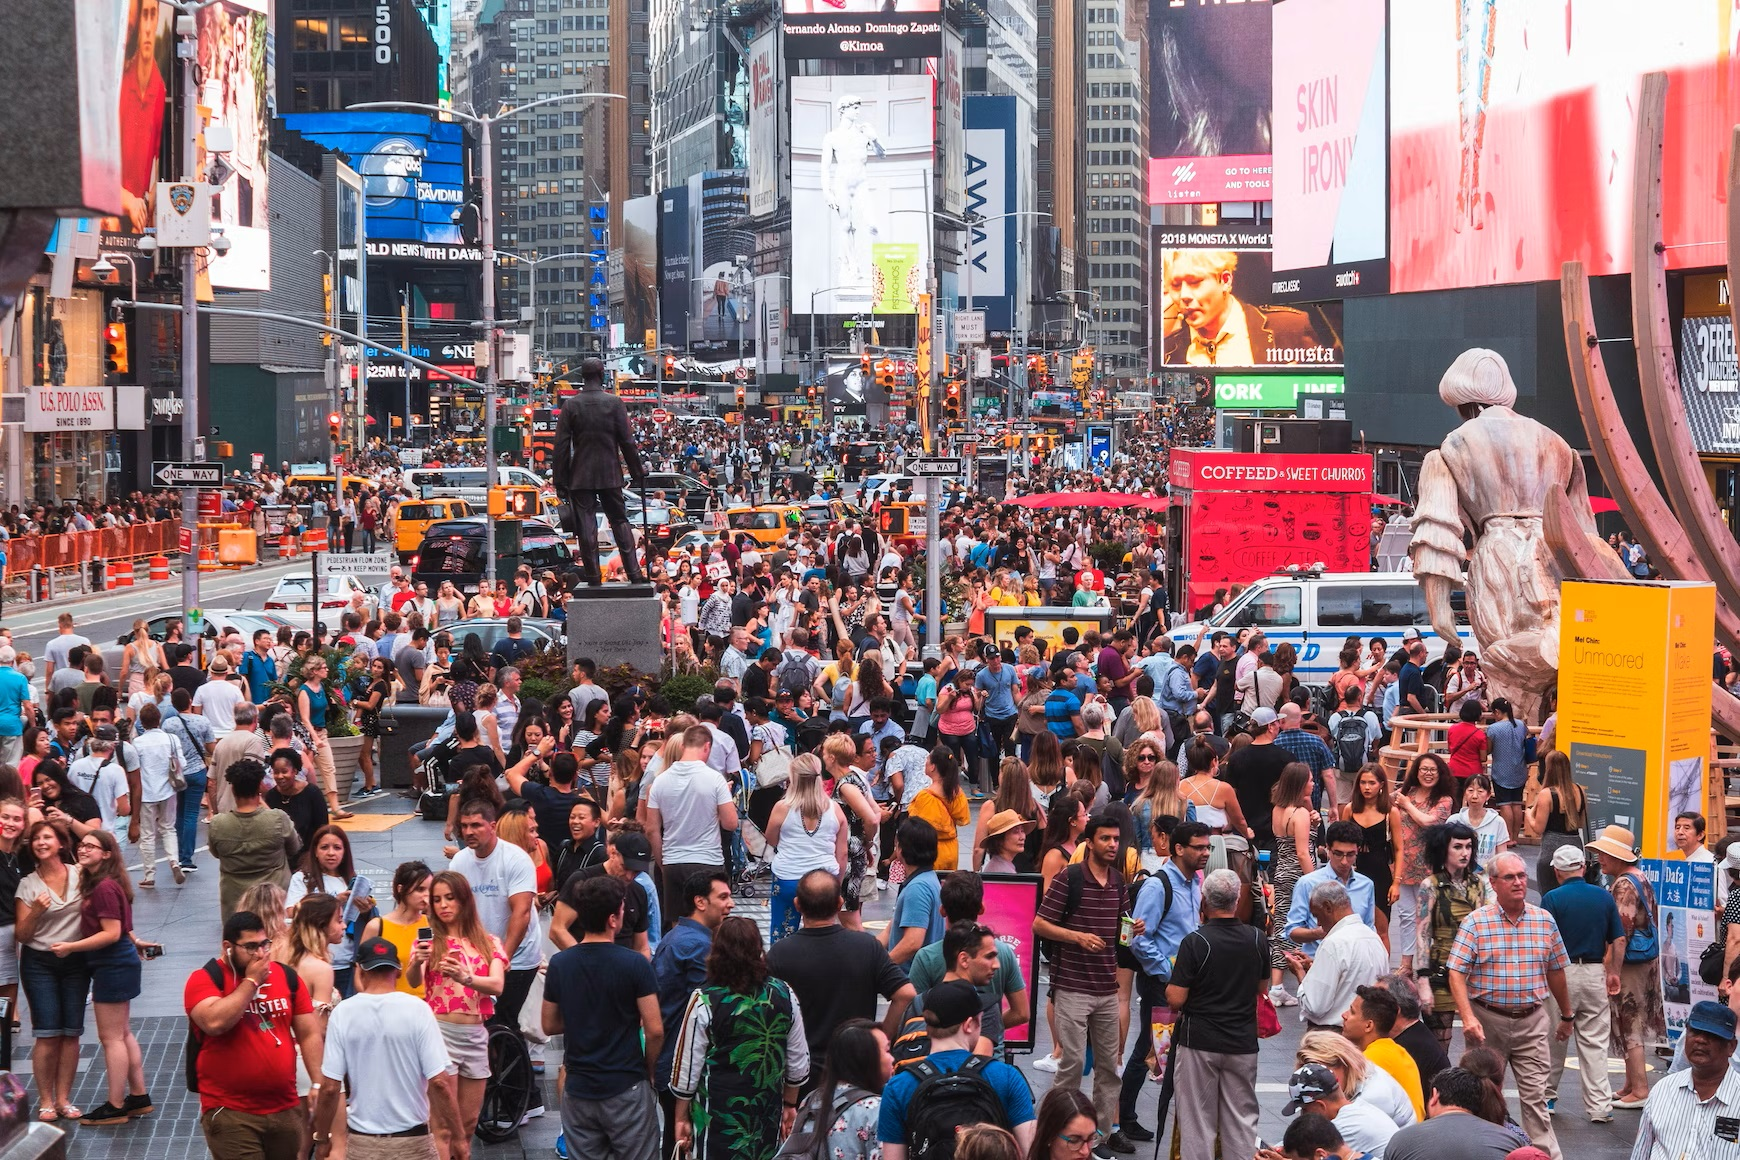
*This image is highly misleading. Less than 0.5% of the Earth's land is cities*

My first dataset consisted of 10,000 images, of which less than 10 contained urban areas. As such, it was a very representative sample, just not of the thing I wanted it to be representative of. What I actually want to represent is "the kind of images users might upload". Representing the Earth as a whole would have been much purer and cleaner but also *totally useless*.

So, in order to compensate, I manually define 17 regions (in addition the 80 randomly generated) that are predominantly urban and suburban. This allows the resulting dataset to contain a broad representation of population densities as well as terrains.

I also needed to make sure the Y labels are actually descriptive of the images. Upon inspecting NASA's dataset, I found that fine-grained, 30 arc-second data actually only exists for relatively few countries, whereas most of the grid is filled out with average values for larger areas. This would have been disastrous for the dataset, as it might have assigned the same, averaged Y value to an image of the centre of a city as to one of a field outside the same city, populated only by cows and crows.

Of the remaining parameters, 'step' specifies 30 arcseconds as the unit size, and the images are formatted to 224x224 for use with a ResNet architecture (the problem of generalizing the predictive algorithm to other image sizes and resolutions will be tackled later). 'max' is the saturation factor which renders the images legible to human eyes. Since the ultimate purpose is to allow humans to upload a satellite image and receive a population estimate, we need our dataset images to be human-friendly.

In the next section, I prepare the regions from which to download images. To ensure that each generated image corresponds to a specific Y value, the top left corner of each region must correspond to a grid corner in the population dataset, and the length and width of the region must be a multiple of the length/width of each population grid (30 arcseconds).

I also ensure that regions are on land and that they are in the above defined countries for which good population data exists.

In [ ]:
def getCorners(roicorners=list()):
  _step = params['step']
  while len(roicorners) < params['regions']:
    #Generate a random set of coordinates that correspond to grid corners:
    x = random.randint(0, 360 // _step)
    y = random.randint(0, 360 // _step)
    x, y = x * _step, y * _step * 0.5
    x, y = -180 + x, -90 + y

    #Ensure that the point is on land:
    if not globe.is_land(y,x):
      continue

    #Ensure that the point is within one of the countries for which quality target data exists:
    point = ee.Geometry.Point([x,y])
    for country in qualitycountries:
      if country.contains(point).getInfo():
        roicorners.append((x,y))
  return roicorners

Then we generate a polygon from each of the region corners we've defined, and contact Earth Engine to prepare imagery for us from within that polygon. The imagery is pieced together of data from multiple satellites, then filtered and sorted by quality and date.

In [ ]:
#Generate grid corner locations by stepping by the grid size:
def getImage(corner):
  _size = params['regionsize']
  #Generate square from northwest corner
  roi = ee.Geometry.Polygon([[[corner[0], corner[1]], [corner[0]+_size,corner[1]], [corner[0]+_size, corner[1]-_size], [corner[0],corner[1]-_size], [corner[0], corner[1]]]], None, False)
  #Load image
  image = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
  .filterBounds(roi) \
  .filterDate('2020-05-01', '2020-09-01') \
  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 5)) \
  .sort('GENERAL_QUALITY') \
  .mosaic() \
  .clip(roi) \
  .select(params['bands'])
  return image

Here's a randomly generated region of interest in Oklahoma, USA:

In [ ]:
#Test display image in true colors
corner = getCorners()[0]
image = getImage(corner)
Map = geemap.Map()
roi = ee.Geometry.Polygon([[[corner[0], corner[1]], [corner[0]+0.5,corner[1]], [corner[0]+0.5, corner[1]-0.5], [corner[0],corner[1]-0.5], [corner[0], corner[1]]]], None, False)
Map.addLayer(image, {'bands': params['bands'], 'max': params['max']}, "Image")
Map.addLayer(roi, {}, "roi", False)
Map.setCenter(image.getInfo()['properties']['system:footprint']['coordinates'][0][0][0] + 0.25, image.getInfo()['properties']['system:footprint']['coordinates'][0][0][1] -0.25)
Map

Map(center=[35.829166666666666, -96.6], controls=(WidgetControl(options=['position', 'transparent_bg'], widget…

Then we need to generate some random center points from within that region to download 30x30 arcsecond images of. We do so by 'stepping' a random number of steps east and a random number of steps south from the corner point we just defined (plus a half step to reach the center of a grid rather than a corner). We also make sure each point we arrive at is on land.

In [ ]:
#Generate random center points within image region corresponding to target dataset grid centers and return them in GeoJSON format:
def getPoints(corner):
  points = []
  while len(points) < params['pointsperregion']:
    y = corner[0] + (random.randint(1, params['regionsize'] // params['step'])-1) * params['step'] + params['step']/2
    x = corner[1] - (random.randint(1, params['regionsize'] // params['step'])-1) * params['step'] - params['step']/2
    if globe.is_land(x,y):
      points.append((y,x))
  return map(geoJSONize, points)

Since I want about 10,000 images, downloading them one by one is too time-consuming. Instead, we collect the download URL for each image and then feed the list to the Pool.starmap method later on to download many at a time. So here, I specify the region and dimensions of the image along with various parameters:

In [ ]:
#Get URLs for minor image download based on center locations and buffer:
def getUrls(image, point):
    point = ee.Geometry.Point(point['coordinates'])
    region = point.buffer(params['step']/2, proj='EPSG:4326').bounds()
    try:
      url = image.getThumbURL({
          'region': region,
          'bands': params['bands'],
          'max': params['max'] + random.randint(-400,400), #Random integer added in order to induce variety in the lighting of the dataset images, to reflect the variety of potential images uploaded by users
          'dimensions': params['dimensions'],
          'format': params['format'],
          'gamma': 1.3
      })
    except Exception as e:
      print(e)
      return None

    return url

You may have noticed a problem here. There is an apparent mismatch between the shape of the image region - a curvilinear orthogonal grid cell of 30x30 arcseconds, and the format of the image, which is a 2D square of 224x224 pixels. This mismatch will cause each image to be slightly distorted according to how far it is from the equator. Fortunately, while such distortion might have been unacceptable in other applications, it does not hamper our present purposes. Since all images are drawn from a specific list of regions which does not contain any polar regions, the distortion will be kept at a level which will not prevent the neural network from learning the features of human settlements - especially given that human settlements already come in countless different shapes and sizes.

With the download URLs in hand, we can set up a download function which will also name and store each image conveniently so it can be matched with its population figure and gathered into a dataset later. Each image is named according to the position of its location in the population data grid. The population data comes in eight geographically sorted arrays of size 10800 x 10800, which explains the sorting of the images into eight folders:

In [ ]:
#Set up for download. Credit to Qiusheng Wu for this snippet:
@retry(tries=200, delay=1, backoff=2)
def getRes(point, url):
  if not url:
    print("Skipping corrupted image")

  else:
    r = requests.get(url, stream=True)
    if r.status_code != 200:
        r.raise_for_status

    #Store and name image files so they're convenient to pair with targets:
    def getPath(coords):
      _step = params['step']
      if coords[1] > 0:
        if coords[0] > 90:
          x = (coords[0] - 90) / _step
          y = (90 - coords[1]) / _step
          return {'directory':'4', 'y': int(y), 'x': int(x)}
        elif 0 < coords[0] < 90:
          x = coords[0] / _step
          y = (90 - coords[1]) / _step
          return {'directory':'3', 'y': int(y), 'x': int(x)}
        elif -90 < coords[0] < 0:
          x = (coords[0] + 90) / _step
          y = (90 - coords[1]) / _step
          return {'directory':'2', 'y': int(y), 'x': int(x)}
        elif coords[0] < -90:
          x = (coords[0] + 180) / _step
          y = (90 - coords[1]) / _step
          return {'directory':'1', 'y': int(y), 'x': int(x)}
      else:
        if coords[0] > 90:
          x = (coords[0] -90) / _step
          y = (coords[1] / _step) * -1
          return {'directory':'8', 'y': int(y), 'x': int(x)}
        elif 0 < coords[0] < 90:
          x = coords[0] / _step
          y = (coords[1] / _step) * -1
          return {'directory':'7', 'y': int(y), 'x': int(x)}
        elif -90 < coords[0] < 0:
          x = (coords[0] + 90) / _step
          y = (coords[1] / _step) * -1
          return {'directory':'6', 'y': int(y), 'x': int(x)}
        elif coords[0] < -90:
          x = (coords[0] + 180) / _step
          y = (coords[1] / _step) * -1
          return {'directory':'5', 'y': int(y), 'x': int(x)}

    ext = params['format']
    out_dir = getPath(point['coordinates'])['directory']
    basename = f"x{str(getPath(point['coordinates'])['x']).zfill(5)}y{str(getPath(point['coordinates'])['y']).zfill(5)}"
    filename = f"{out_dir}/{params['prefix']}{basename}.{ext}"
    with open(filename, 'wb') as outfile:
        shutil.copyfileobj(r.raw, outfile)
    print(f"{basename} downloaded.\n")

Now we're ready to execute! 🚀

In [ ]:
#Main: get download URLs and coordinates, download images:
#Generate upper left corners of larger images:
rois = getCorners()

#Add cities:
if params['test'] == False:
  rois.extend(CITIES)

for num, roi in enumerate(rois):
  print(f"New region: {num+1}. {roi}")
  #For each region, generate an image of the region:
  image = getImage(roi)
  #...generate a set of point objects within the region from which to generate image chips:
  items = tuple(getPoints(roi))
  #...make a list of copies of the region image so each point object is paired with the image:
  images = [image] * len(items)
  #...send image and each point object to Earth Engine and retrieve image chip download URLs:
  urls = map(getUrls, images, items)
  #...pack each URL and each point object together for multiprocessing download (downloading many images simultaneously to save time) and subsequent storing:
  iter = zip(items, urls)

  #...initialize multiprocessing
  logging.basicConfig()
  pool = multiprocessing.Pool(params['processes'])

  #...download images:
  pool.starmap(getRes, iter)

  #...and close down multiprocessing once all images in this region have been downloaded:
  pool.close()


We now have 10,000 224x224 satellite images of 30x30 arcsecond areas on Earth. The next stage is sanitizing this data to make sure each image will actually help the neural network learn to estimate population. The best way to do this is by the highly useful technique of looking at them.

In [ ]:
#Download image files to hard disk
from google.colab import files
for i in range(1,9):
  !zip -r /content/zips/{i}.zip /content/{i}
  files.download(f'/content/zips/{i}.zip')

After removing all cloud-covered images, bugged images, superfluous images and sea images (coastal areas may cause problems because global_land_mask library's shapefile, which we used to make sure only to download land images, does not correspond to 100% to NASA's coastline shapefile, and sea grid cells have a population of -9999 in NASA's dataset rather than 0), there were 9118 left.

Now it's time to import some more libraries and make the dataset.

In [ ]:
#Import tools required for setting up our model:
import numpy as np
import cv2
import torch
import os.path
import math

There's still a lot of work to be done before this data can be fed into a neural network. PyTorch neural networks require inputs to be in the form of tensors (immutable, multidimensional arrays that can be processed by a GPU). When using the ResNet architecture, as I plan to do, the image tensors also need to be normalized. Images need to be stored as RGB instead of BGR (as provided by Earth Engine), and finally, each image needs to be paired with its Y (population) value.

As you can see below, I actually use the log of the population count. This is because I want relative error to matter rather than absolute error. If my model predicts 9,000 instead of 8,000, that is as bad an error as if it predicts 90 instead of 80. With actual population counts, the former would be treated as 100 times worse, and therefore the model would only learn to predict the highest populated areas.

In [ ]:
#Load population grids into arrays and pair up saved images with population counts
prefix = "Population"
ext = ".asc"
path = "drive/MyDrive/PopulationData/"
pathext = 'content/'
popdatafilename = 'gpw_v4_population_count_rev11_2020_30_sec_'
dataset = []
for i in [1,2,3,6,7,8]:
  array = np.loadtxt(f"{path}{popdatafilename}{i}{ext}", skiprows=6)
  for filename in sorted(os.listdir(f"{path}{pathext}{i}")):
    if filename[12:16] != ".png":
      continue

    column = int(filename[1:6])
    row = int(filename[7:12])
    depvar = array[row,column]

    #Convert image to array and reshape array to RGB as our model will expect:
    image = cv2.imread(f"{path}{pathext}{i}/{filename}", cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    #Normalize the image according to the standard for ResNet, which we will be using for transfer learning:
    normalize = TF.Compose([
        TF.ToTensor(),
        TF.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    normalizedimage = normalize(image)
    del image

    #Convert target value to tensor, pack image tensor with log of target value tensor, and convert
    #target value tensor to the format expected by the neural network:
    depvar = torch.log(torch.from_numpy(np.array(depvar))+1).to(torch.float32)

    #Make sure to skip any NaN target values:
    if depvar > 1 or depvar < 1 or depvar == 1:
      #Add item to dataset:
      dataset.append((normalizedimage, depvar))
  del array

#Save dataset to file:
torch.save(dataset, "drive/MyDrive/PopulationData/dataset2.t")

len(dataset)

9103

After removing any NaN values that might have remained (grid cells considered sea by NASA's population grid, whose -9999 value will become NaN after taking the log, but which I did not catch while looking through the dataset manually) the size is now 9103.

In [ ]:
#Load dataset
dataset = torch.load("drive/MyDrive/PopulationData/dataset2.t")
len(dataset)

9103

With a dataset prepped and ready, it's time to set up our neural network. This is always a voyage into unchartered waters. The best path forward depends entirely on the specific dataset and is therefore impossible to know in advance.

What's quite obvious, though, is that Deep Learning with a convolutional network (CNN) is the best approach. This is nearly always the case when working with images because the convolutional layers of the network allow the model to recognize features within an image (in this case things like houses and streets), rather than only being able to consider the entirety of the image.

So the big question is how to create a CNN with the right hyperparameters for this particular task. In the following, I try to abide by [the advice of Machine Learning legend Andrej Karpathy](http://karpathy.github.io/2019/04/25/recipe/):

"*be thorough, defensive, paranoid, and obsessed with visualizations of basically every possible thing*"

The idea is to employ an iterative approach, starting small and adding one feature at a time so as to be able to tell *what's* gone wrong when something goes wrong.

⚠️ Note that this stage of the project remains unfinished ⚠️

In [ ]:
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split

To start off, I'm defining a simple model architecture with two convolutional layers:

In [ ]:
#Define test model architecture
class SmallConvNet(nn.Module):
    def __init__(self):
        super(SmallConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=5, stride=1, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(56 * 56 * 16, 1)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.fc(self.flatten(self.maxpool(self.relu(self.conv2(self.relu(self.conv1(x)))))))
        x = x.squeeze(1)
        return x

The purpose of this model is merely to get the network to train and to make sure training loss goes down. Having ascertained that, I can then return and optimize it later. Now it's time to set some hyperparameters:

In [ ]:
#Neural network setup:

model = SmallConvNet()

#Hyperparameters:
hyperparameters = {
    'train_pct': 0.8,
    'epochs': 20,
    'learning_rate': 0.0003,
    'batch_size': 64,
}

#Specify device to use for training:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

#Specify loss function to use:
criterion = nn.MSELoss()

#Specify optimizer:
optimizer = optim.SGD(model.parameters(), lr=hyperparameters['learning_rate'])

#Split the dataset randomly into a training set and a validation set
train, valid = random_split(dataset, [hyperparameters['train_pct'],1-hyperparameters['train_pct']])

#Instantiate the custom dataset and store the data as DataLoader objects, which are iterators that provide the data to the model one batch at a time.
#The data is now ready to be input into the model.
tdl = DataLoader(dataset=train, batch_size=hyperparameters['batch_size'], shuffle=True)
vdl = DataLoader(dataset=valid, batch_size=hyperparameters['batch_size'], shuffle=True)


I'm keeping it simple for now, using a constant learning rate and no transformations. My loss function is mean squared error, which I've chosen over mean absolute error because I want big errors to be punished more. Remember that I'm using the log of the population count so the difference will only be felt when a prediction is off by several orders of magnitude.

Next step is to set up an evaluation function to get ample feedback on how the model is performing:

In [ ]:
#Define evaluation function for model
def accuracy(valid):
  #Initialize variables:
  eval = {}
  eval['validloss'] = 0.0
  eval['metrics'] = {}
  eval['metrics']['c_50'] = 0
  eval['metrics']['c_mag'] = 0
  eval['metrics']['c_10'] = 0

  #Test the model against the validation set:
  for x, y in valid:
    x = x.to(device)
    y = y.to(device)
    preds = model(x)
    loss = criterion(preds, y)
    eval['validloss'] += loss.item()

    #Calculate precision metrics (amount of exact predictions (within -10% to +10% of target), amount of roughly accurate predictions
    #(within half to double the target) and amount of predictions in roughly the correct order of magnitude (within 1/10 and 10/1 of target):
    for prediction, target in zip(preds.flatten(), y.flatten()):
      target = math.exp(target.item())
      prediction = math.exp(prediction.item())
      if target / 2 < prediction < target * 2:
        eval['metrics']['c_50'] += 1
      if target / 10 < prediction < target * 10:
        eval['metrics']['c_mag'] += 1
      if target * 0.9 < prediction < target * 1.1:
        eval['metrics']['c_10'] += 1
    del x
    del y
    del preds
    del loss
  return eval

Note that I'm deleting the variables after each iteration of the for loop in order to avoid GPU memory overload.

Now we can try training our model to see how it does. For learning purposes, I'm doing all the setup and training in pure PyTorch instead of using high-level libraries such as Lightning or FastAI.

The training loop below is pretty standard stuff. The only thing to note is that I'm saving batch count, gradients and parameters for inspection afterwards.

In [ ]:
#Fit the model to our dataset:
optimizer.zero_grad()
for epoch in range(hyperparameters['epochs']):
  running_loss = 0.0
  batchcount = 0
  grads = []
  parameters = []
  for x, y in tdl:
    x = x.to(device)
    y = y.to(device)
    batchcount += 1
    optimizer.zero_grad()
    preds = model(x)
    loss = criterion(preds, y)
    loss.backward()
    for p in model.parameters():
      grads.append(p.grad)
      parameters.append(p.data)
    optimizer.step()
    running_loss += loss

  #Print statistics after each epoch
  eval = accuracy(vdl)
  print(f"Epoch {epoch + 1} finished.")
  print(f"Training loss: {running_loss:.4f}")
  print(f"Validation loss: {eval['validloss'] * 4:.4f}")
  print(f"Perfect: {eval['metrics']['c_10'] / len(vdl.dataset) * 100:.2f}%")
  print(f"Correct half to double: {eval['metrics']['c_50'] / len(vdl.dataset) * 100:.2f}%")
  print(f"Correct order of magnitude: {eval['metrics']['c_mag'] / len(vdl.dataset) * 100:.2f}%\n")

Epoch 1 finished.
Training loss: 1423.7526
Validation loss: 1146.7952
Perfect: 6.21%
Correct half to double: 38.35%
Correct order of magnitude: 86.37%

Epoch 2 finished.
Training loss: 1101.3892
Validation loss: 1096.3834
Perfect: 5.27%
Correct half to double: 37.58%
Correct order of magnitude: 87.91%

Epoch 3 finished.
Training loss: 960.3906
Validation loss: 1207.3080
Perfect: 6.65%
Correct half to double: 42.69%
Correct order of magnitude: 85.82%

Epoch 4 finished.
Training loss: 829.8329
Validation loss: 1182.7006
Perfect: 5.93%
Correct half to double: 35.22%
Correct order of magnitude: 86.87%

Epoch 5 finished.
Training loss: 715.6531
Validation loss: 1114.2927
Perfect: 6.65%
Correct half to double: 43.68%
Correct order of magnitude: 86.92%

Epoch 6 finished.
Training loss: 667.1947
Validation loss: 1198.5544
Perfect: 6.15%
Correct half to double: 46.26%
Correct order of magnitude: 85.71%

Epoch 7 finished.
Training loss: 603.1055
Validation loss: 1235.4410
Perfect: 7.86%
Correct 

As expected, we're not quite there yet, with only 7% of the predicted population counts in the validation set being accurate to within 10%. However, the important thing to note is that training loss steadily decreases through the epochs. This means that the network is working. It is merely overfitting - which we will try to amend in the next iterations 🙂

In [ ]:
torch.save(model, f'drive/MyDrive/PopulationData/model{state}.pkl')

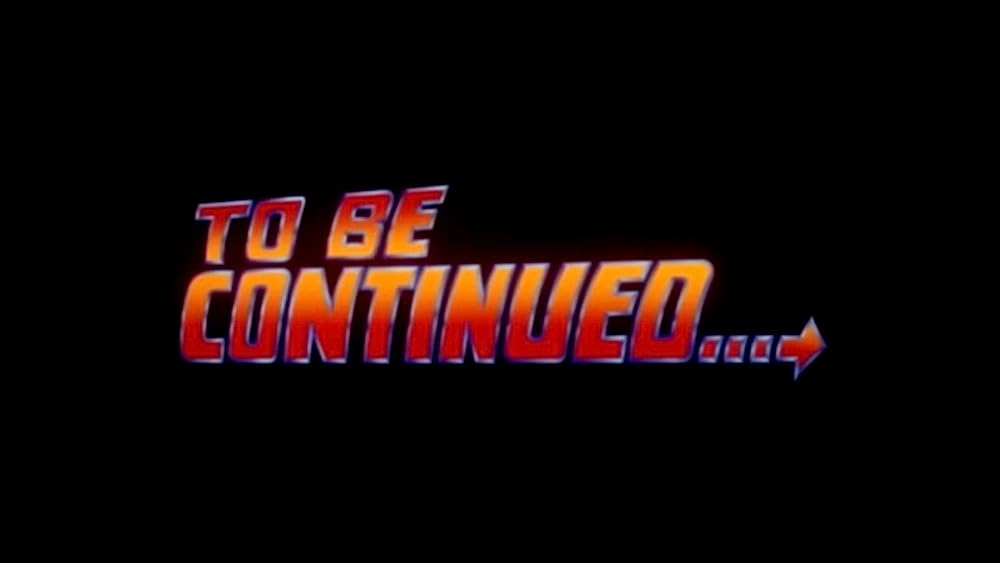